In [1]:
import os
from pyspark.sql import SparkSession


runLocal = True

if runLocal:
    spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
else:
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Spark Try') \
        .getOrCreate()
    print 'Spark Session web UI: http://{}:4040'.format(ip)

In [47]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division

import re
import matplotlib.pyplot as plt
import seaborn
import pyspark.sql.functions
import functools
%matplotlib inline  


In [3]:
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

In [11]:
sentRegex = re.compile(r'(?=\S)\.\s+(?=[A-Z])')

@pyspark.sql.functions.udf
def sentenceSplit(s):
    return [sent.strip() for sent in re.split(sentRegex, s)]

sentencesDF = df.withColumn('sentences', sentenceSplit(df.text)).withColumn('year_int', df.year.cast('int'))
sentencesDF.show(5)

+--------------------+--------------------+----+--------------------+--------+
|           president|                text|year|           sentences|year_int|
+--------------------+--------------------+----+--------------------+--------+
|        James Monroe| Fellow-Citizens ...|1821|[Fellow-Citizens ...|    1821|
|    William McKinley| To the Senate an...|1897|[To the Senate an...|    1897|
|Dwight D. Eisenhower|[Delivered in per...|1960|[[Delivered in pe...|    1960|
|     Calvin Coolidge|Since the close o...|1923|[Since the close ...|    1923|
|       James Madison| Fellow-Citizens ...|1816|[Fellow-Citizens ...|    1816|
+--------------------+--------------------+----+--------------------+--------+
only showing top 5 rows



Sentences have been found and are in the `sentences` column of the dataframe

In [36]:
wordRegex = re.compile(r'\s+')

@pyspark.sql.functions.udf
def wordsplit(sents):
    return [re.split(wordRegex, sent) for sent in sents]

@pyspark.sql.functions.udf
def sentLengths(splitSents):
    return [len(sent) for sent in splitSents]

@pyspark.sql.functions.udf
def countSents(sents):
    return len(sents)

@pyspark.sql.functions.udf
def avgNumWords(numSents):
    l = len(numSents)
    return sum(numSents) / l


wordDF = sentencesDF.withColumn('words', wordsplit(sentencesDF.sentences))
wordDF = wordDF.withColumn('num_words', sentLengths(wordDF.words))
wordDF = wordDF.withColumn('num_sents', countSents(wordDF.sentences))
wordDF = wordDF.withColumn('avgNum_words', avgNumWords(wordDF.num_words))

perYear = wordDF.orderBy(wordDF.year_int.asc()).groupby('year_int').agg({'avgNum_words' : 'mean', 'num_sents' : 'mean'})

In [44]:
perYearDF = perYear.toPandas()

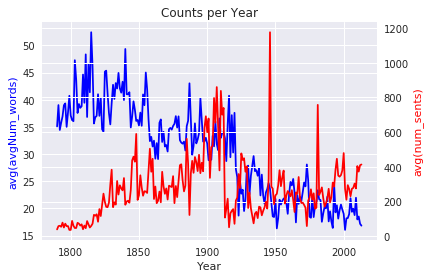

In [70]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(perYearDF['year_int'], perYearDF['avg(avgNum_words)'], color = 'b')
ax.set_ylabel('avg(avgNum_words)', color='b')

ax2.plot(perYearDF['year_int'], perYearDF['avg(num_sents)'], color = 'r')
ax2.set_ylabel('avg(num_sents)', color='r')

ax.set_xlabel('Year')
ax.set_title("Counts per Year")
plt.show()

In [35]:
wordsPerYear.show()

+--------+------------------+--------------+
|year_int| avg(avgNum_words)|avg(num_sents)|
+--------+------------------+--------------+
|    1790|            35.075|          40.0|
|    1791|39.016949152542374|          59.0|
|    1792| 34.42622950819672|          61.0|
|    1793|35.763636363636365|          55.0|
|    1794|36.924050632911396|          79.0|
|    1795| 38.98039215686274|          51.0|
|    1796| 39.31506849315068|          73.0|
|    1797|              35.0|          59.0|
|    1798|  37.6271186440678|          59.0|
|    1799|40.729729729729726|          37.0|
|    1800| 37.08108108108108|          37.0|
|    1801|36.247191011235955|          89.0|
|    1802|36.049180327868854|          61.0|
|    1803|47.270833333333336|          48.0|
|    1804|43.708333333333336|          48.0|
|    1805| 37.55128205128205|          78.0|
|    1806|39.205479452054796|          73.0|
|    1807|              38.5|          62.0|
|    1808| 38.79710144927536|          69.0|
|    1809|

In [ ]:
wordDF.year_int.a